Version: 02.14.2023

# Challenge Lab 6.3: Implementing Topic Modeling

In this lab, you will use either Amazon Comprehend or the Amazon SageMaker Neural Topic Model (NTM) to extract topics from the [CMU Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). 

## CMU Movie Summary Corpus

The CMU Movie Summary Corpus is a collection of 42,306 movie plot summaries and metadata at both the movie level (including box office revenue, genre, and date of release) and character level (including gender and estimated age).  This data supports work in the following paper:

David Bamman, Brendan O'Connor, and Noah Smith. "Learning Latent Personas of Film Characters." Presented at the Annual Meeting of the Association for Computational Linguistics (ACL 2013), Sofia, Bulgaria, August 2013. http://www.cs.cmu.edu/~dbamman/pubs/pdf/bamman+oconnor+smith.acl13.pdf.

You will use two datasets in this lab:

**plot_summaries.txt**

This dataset contains plot summaries of 42,306 movies, extracted from the November 2, 2012 dump of English-language Wikipedia. Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.

**movie.metadata.tsv**

This dataset contains metadata for 81,741 movies, extracted from the November 4, 2012 dump of Freebase. The data is tab-separated and contains the following columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)

## Lab steps

To complete this lab, you will follow these steps:

1. [Installing the packages](#1.-Installing-the-packages)
2. [Reviewing the dataset](#2.-Reviewing-the-dataset)
3. [Extracting topics](#3.-Extracting-topics)

## Submitting your work

1. In the lab console, choose **Submit** to record your progress and when prompted, choose **Yes**.

1. If the results don't display after a couple of minutes, return to the top of these instructions and choose **Grades**.

     **Tip**: You can submit your work multiple times. After you change your work, choose **Submit** again. Your last submission is what will be recorded for this lab.

1. To find detailed feedback on your work, choose **Details** followed by **View Submission Report**.

## 1. Installing the packages
([Go to top](#Challenge-Lab-6.3:-Implementing-Topic-Extraction))

First, update and install the packages that you will use in the notebook.

In [1]:
%matplotlib inline

import boto3
import os, io, struct, json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import uuid
from time import sleep
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

Matplotlib is building the font cache; this may take a moment.
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.22.4)
  from scipy.stats import gaussian_kde
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...


In [2]:
bucket = "c127808a3228852l7966294t1w213462189212-labbucket-qorf2dsjazvm"
job_data_access_role = 'arn:aws:iam::213462189212:role/service-role/c127808a3228852l7966294t1w-ComprehendDataAccessRole-3ejw5UqNDmg6'
prefix='lab63'

## 2. Reviewing the dataset
([Go to top](#Challenge-Lab-6.3:-Implementing-Topic-Extraction))

First, load the plot_summaries.tsv data into a pandas DataFrame.

The file contains two columns: **movie_id** and **plot**. The data is tab-separated, and the '\t' escape sequence is used as the separator.

In [3]:
df = pd.read_csv('../data/plot_summaries.tsv', sep='\t', names=['movie_id','plot'])

Review the first few rows of data to get an overview of how the data is structured.

In [4]:
pd.options.display.max_rows
pd.set_option('display.max_colwidth', None)

df.head(5)

movie_id  \
0  23890098   
1  31186339   
2  20663735   
3   2231378   
4    595909   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

To check the number of rows and columns, use the `shape` property.

In [5]:
df.shape

(42303, 2)

Now examine the metadata. The [dataset documentation](http://www.cs.cmu.edu/~ark/personas/data/README.txt) explains that the data contains nine fields. Load the data into a pandas DataFrame and specify the column names.

In [6]:
movie_meta_df = pd.read_csv('../data/movie.metadata.tsv', sep='\t', names=['movie_id','freebase_id','name','release_date','box_office_revenue','runtime','languages','countries','genres'])
movie_meta_df.head()

,movie_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


Set the index to **movie_id**, which will make it easier to merge this dataset with the plot.

In [7]:
movie_meta_df.set_index('movie_id', inplace=True)

Because you only need the movie name and something to link this metadata to the plot (**movie_id**), drop the remaining columns.

In [8]:
movie_meta_df=movie_meta_df.drop(['freebase_id','release_date','box_office_revenue','runtime','languages','countries','genres'], axis=1)
movie_meta_df.head()

,name
movie_id,
975900,Ghosts of Mars
3196793,Getting Away with Murder: The JonBenét Ramsey Mystery
28463795,Brun bitter
9363483,White Of The Eye
261236,A Woman in Flames


## 3. Extracting topics
([Go to top](#Challenge-Lab-6.3:-Implementing-Topic-Extraction))

You must now decide if you are going to use Amazon Comprehend or the SageMaker NTM algorithm to extract your topics. Both will do a good job of giving you topics, but each has different data requirements.

Refer to the notebooks from labs 6.1 and 6.2 for any code snippets you might need for each solution. Experiment with the number of topics to see if you can get better results. 

Questions to address:

1. What data cleanup do you need to perform?

2. How many topics will give you the best results?

In [9]:
import string
from tqdm import tqdm
tqdm.pandas()


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
punctuation = set(string.punctuation)


def clean_text(text):
    text = text.strip().replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    text = text.lower()
    if text.startswith('plot '): text = text[5:]
    tokens = nltk.word_tokenize(text)
    cleaned_tokens = [
        lemmatizer.lemmatize(token) 
        for token in tokens 
        if token not in stop_words and token not in punctuation and token.isalpha()
    ]
    cleaned_text = " ".join(cleaned_tokens)
    
    return cleaned_text


df['clean_plot'] = df['plot'].progress_apply(clean_text)

100%|██████████| 42303/42303 [01:50<00:00, 384.12it/s]


In [10]:
print(df.loc[0, 'plot'])
print()
print(df.loc[0, 'clean_plot'])

Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.

shlykov taxi driver lyosha saxophonist develop bizarre relationship despite prejudice realize different


In [11]:
data = df['clean_plot']
with open('comprehend_input.txt','w', encoding='UTF-8') as cf:
    for line in tqdm(data):
        cf.write(line+'\n')

100%|██████████| 42303/42303 [00:00<00:00, 477229.77it/s]


In [12]:
s3 = boto3.resource('s3')
s3.Bucket(bucket).upload_file('comprehend_input.txt', 'comprehend/movies')

In [13]:
number_of_topics = 15

input_s3_url = f"s3://{bucket}/comprehend"
input_doc_format = "ONE_DOC_PER_LINE"
input_data_config = {"S3Uri": input_s3_url, "InputFormat": input_doc_format}

output_s3_url = f"s3://{bucket}/outputfolder/"
output_data_config = {"S3Uri": output_s3_url}

job_uuid = uuid.uuid1()
job_name = f"top-job-{job_uuid}"

print(input_s3_url)

s3://c127808a3228852l7966294t1w213462189212-labbucket-qorf2dsjazvm/comprehend


In [14]:
comprehend_client = boto3.client(service_name='comprehend')
start_topics_detection_job_result = comprehend_client.start_topics_detection_job(NumberOfTopics=number_of_topics,
                                                                              InputDataConfig=input_data_config,
                                                                              JobName=job_name,
                                                                              OutputDataConfig=output_data_config,
                                                                              DataAccessRoleArn=job_data_access_role
                                                                            )

In [15]:
# Get current job status
from time import sleep
job = comprehend_client.describe_topics_detection_job(JobId=start_topics_detection_job_result['JobId'])

# Loop until job is completed
waited = 0
timeout_minutes = 40
while job['TopicsDetectionJobProperties']['JobStatus'] != 'COMPLETED':
    sleep(60)
    waited += 60
    assert waited // 60 < timeout_minutes, "Job timed out after %d seconds." % waited
    print('.', end='')
    job = comprehend_client.describe_topics_detection_job(JobId=start_topics_detection_job_result['JobId'])

print('\nReady')

..............................
Ready


In [16]:
topic_comprehend_output_file = job['TopicsDetectionJobProperties']['OutputDataConfig']['S3Uri']
print(f'output filename: {topic_comprehend_output_file}')

topics_comprehend_bucket, topics_comprehend_key = topic_comprehend_output_file.replace("s3://", "").split("/", 1)
print(topics_comprehend_key)
s3r = boto3.resource('s3')
s3r.meta.client.download_file(topics_comprehend_bucket, topics_comprehend_key, 'output.tar.gz')

output filename: s3://c127808a3228852l7966294t1w213462189212-labbucket-qorf2dsjazvm/outputfolder/213462189212-TOPICS-d07cac266e4df0af055f6f271547321f/output/output.tar.gz
outputfolder/213462189212-TOPICS-d07cac266e4df0af055f6f271547321f/output/output.tar.gz


In [17]:
# Extract the .tar file
import tarfile
tf = tarfile.open('output.tar.gz')
tf.extractall()

In [18]:
import pandas as pd
dftopicterms = pd.read_csv("topic-terms.csv")
dftopicterms.head()

,topic,term,weight
0,0,world,0.005669
1,0,kill,0.007764
2,0,attack,0.003992
3,0,soldier,0.003722
4,0,group,0.004625


In [19]:
# Selecting rows based on condition
for t in range(number_of_topics):
    rslt_df = dftopicterms.loc[dftopicterms['topic'] == t]
    topic_list = rslt_df['term'].values.tolist()
    print(f'Topic {t:2} - {topic_list}')

Topic  0 - ['world', 'kill', 'attack', 'soldier', 'group', 'german', 'ship', 'escape', 'army', 'american']
Topic  1 - ['gang', 'police', 'kill', 'money', 'brother', 'steal', 'bank', 'criminal', 'officer', 'plan']
Topic  2 - ['life', 'change', 'story', 'day', 'live', 'film', 'friend', 'make', 'world', 'time']
Topic  3 - ['murder', 'police', 'find', 'kill', 'killer', 'detective', 'investigate', 'case', 'officer', 'suspect']
Topic  4 - ['girl', 'boy', 'love', 'story', 'film', 'child', 'young', 'village', 'find', 'mother']
Topic  5 - ['film', 'story', 'show', 'character', 'scene', 'base', 'director', 'movie', 'star', 'shoot']
Topic  6 - ['jerry', 'bug', 'cat', 'house', 'back', 'mouse', 'run', 'chase', 'play', 'daffy']
Topic  7 - ['father', 'mother', 'daughter', 'child', 'boy', 'find', 'home', 'brother', 'year', 'death']
Topic  8 - ['family', 'film', 'home', 'brother', 'house', 'return', 'live', 'town', 'story', 'sister']
Topic  9 - ['wife', 'husband', 'child', 'marry', 'woman', 'affair', '

In [20]:
colnames = pd.DataFrame({'topics': [f'topic {i}' for i in range(20)]})
dfdoctopics = pd.read_csv("doc-topics.csv")
dfdoctopics.head()

,docname,topic,proportion
0,movies:10,7,0.580719
1,movies:10,1,0.247584
2,movies:10,9,0.171696
3,movies:45,14,0.412867
4,movies:45,1,0.322484


In [22]:
to_chart = dfdoctopics.loc[dfdoctopics['docname'].isin([f'movies:{i * 1000}' for i in range(1, 6)])]
to_chart = to_chart.pivot_table(values='proportion', index='topic', columns='docname')
to_chart.head()

docname,movies:1000,movies:2000,movies:3000,movies:4000,movies:5000
topic,,,,,
0,0.403618,NaN,NaN,0.141259,NaN
1,NaN,NaN,NaN,NaN,0.209852
2,NaN,1.0,0.192621,NaN,NaN
3,NaN,NaN,NaN,0.389390,0.192876
5,0.257050,NaN,NaN,NaN,NaN


Text(0.5, 0, 'Topic ID')

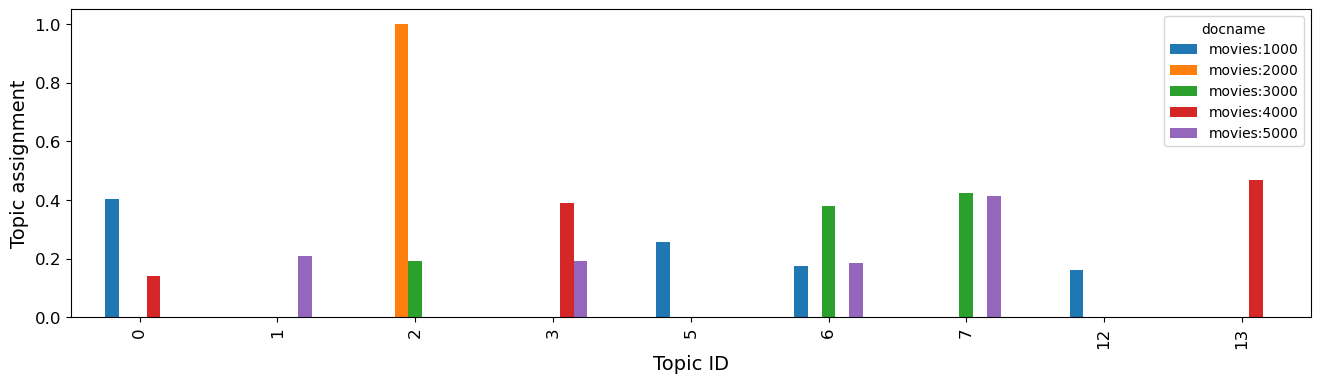

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

fs = 12
#df.index = colnames['topic']
to_chart.plot(kind='bar', figsize=(16,4), fontsize=fs)
plt.ylabel('Topic assignment', fontsize=fs+2)
plt.xlabel('Topic ID', fontsize=fs+2)

# Congratulations!

You have completed this lab, and you can now end the lab by following the lab guide instructions.

*©2023 Amazon Web Services, Inc. or its affiliates. All rights reserved. This work may not be reproduced or redistributed, in whole or in part, without prior written permission from Amazon Web Services, Inc. Commercial copying, lending, or selling is prohibited. All trademarks are the property of their owners.*
